In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pandas as pd
import pytensor.tensor as pt
import numpy.ma as ma
from scipy.stats import norm 
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 8})

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
#Read data from sample_dataset.csv

df = pd.read_csv('sample_dataset.csv')
Nsites=df.shape[0]
df.drop(['Sites','X','Y'], axis=1, inplace=True)
data_source = df.to_numpy()

In [3]:
#Read data from adjacency_matrix.csv

df = pd.read_csv('adjacency_matrix.csv',header=None)
adj_matrix = df.to_numpy()


In [4]:

UPM_CAR = pm.distributions.multivariate.CARRV(ndims_params = [1, 2, 0, 1]) #Monkeypatching (source-code modification)
pm.CAR.rv_op = UPM_CAR #Monkeypatching (source-code modification)


#prep the data
data=data_source
datatrans = data.transpose()

# Bayesian modelling
coords = {"Nsites":np.arange(Nsites)}
with pm.Model(coords=coords) as model:
    sd = pm.Uniform("sd",lower=0,upper=2,dims="Nsites",initval=np.repeat(0.1,Nsites))
    beta0 = pm.Uniform("beta0", lower=0,upper=4,initval=0.1)
    tau=sd*sd
    alpha=0.99
    #alpha = pm.Beta("alpha", alpha=1, beta=1)
    phi= pm.CAR ("phi", mu=np.zeros(Nsites),tau=tau, W=adj_matrix, alpha=alpha, dims="Nsites",initval=np.repeat(0.01,Nsites) )
    mu = pm.Deterministic("mu", beta0+phi)
    obs = pm.Normal("obs", mu=mu, sigma=sd, observed=datatrans)
    idata = pm.sample(draws=500,tune=1000,compute_convergence_checks=False)


/usr/local/lib/python3.9/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, beta0, phi, obs_unobserved]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 226 seconds.


In [5]:
az.summary(idata, var_names=["mu","sd"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],1.562,0.570,0.599,2.661,0.040,0.028,209.0,608.0,1.01
mu[1],1.520,0.484,0.556,2.365,0.036,0.026,179.0,535.0,1.01
mu[2],1.411,0.389,0.673,2.120,0.026,0.019,218.0,750.0,1.00
mu[3],1.691,0.415,0.890,2.437,0.027,0.019,234.0,742.0,1.01
mu[4],1.798,0.447,0.979,2.648,0.030,0.021,222.0,744.0,1.01
...,...,...,...,...,...,...,...,...,...
sd[44],1.959,0.039,1.885,2.000,0.001,0.001,2105.0,1164.0,1.00
sd[45],1.960,0.039,1.887,2.000,0.001,0.000,2086.0,1018.0,1.00
sd[46],1.959,0.040,1.889,2.000,0.001,0.000,1992.0,1197.0,1.00
sd[47],1.960,0.040,1.884,2.000,0.001,0.000,2863.0,964.0,1.00


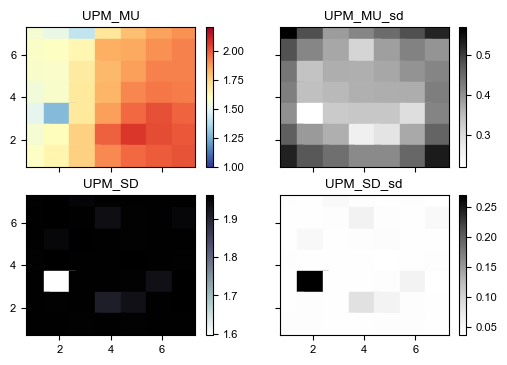

In [6]:
#plot_Posterior_idata_min
posterior_mean =az.summary(idata, var_names=["mu"])
posterior_sd =az.summary(idata, var_names=["sd"])

UPM_MU = posterior_mean["mean"]
UPM_SD = posterior_sd["mean"]
UPM_MU_sd = posterior_mean["sd"]
UPM_SD_sd = posterior_sd["sd"]

df = pd.read_csv('sample_dataset.csv')
x = df["X"].to_numpy()
y = df["Y"].to_numpy()
z1 = UPM_MU.to_numpy()
z2 = UPM_MU_sd.to_numpy()
z3 = UPM_SD.to_numpy()
z4 = UPM_SD_sd.to_numpy()

fig, axs = plt.subplots(2,2, sharex='col', sharey='row',figsize=(6, 4))

z1_cm = plt.cm.get_cmap('RdYlBu_r')
z2_cm = plt.cm.get_cmap('Greys')
z3_cm = plt.cm.get_cmap('bone_r')

z1_sc=axs[0,0].scatter(x, y, c=z1, vmax=2.2, vmin=1,s=500,cmap=z1_cm, marker="s")
fig.colorbar(z1_sc)
axs[0][0].set_title("UPM_MU")

z2_sc=axs[0,1].scatter(x, y, c=z2, s=500,cmap=z2_cm, marker="s")
fig.colorbar(z2_sc)
axs[0][1].set_title("UPM_MU_sd")

z3_sc=axs[1,0].scatter(x, y, c=z3,s=500,cmap=z3_cm, marker="s")
fig.colorbar(z3_sc)
axs[1][0].set_title("UPM_SD")

z4_sc=axs[1,1].scatter(x, y, c=z4, s=500,cmap=z2_cm, marker="s")
fig.colorbar(z4_sc)
axs[1][1].set_title("UPM_SD_sd")


plt.show()

fig.savefig('UPM_Map.png')
